I've implemented the integral of wt in pearce. This notebook verifies it works as I believe it should. 

In [1]:
from pearce.mocks import cat_dict
import numpy as np
from os import path
from astropy.io import fits

In [2]:
import matplotlib
#matplotlib.use('Agg')
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

Load up the tptY3 buzzard mocks. 

In [3]:
fname = '/u/ki/jderose/public_html/bcc/measurement/y3/3x2pt/buzzard/flock/buzzard-2/tpt_Y3_v0.fits'
hdulist = fits.open(fname)

In [4]:
hdulist.info()

Filename: /u/ki/jderose/public_html/bcc/measurement/y3/3x2pt/buzzard/flock/buzzard-2/tpt_Y3_v0.fits
No.    Name         Type      Cards   Dimensions   Format
  0  PRIMARY     PrimaryHDU       4   ()      
  1  xip         BinTableHDU     32   200R x 5C   [K, K, K, D, D]   
  2  xim         BinTableHDU     32   200R x 5C   [K, K, K, D, D]   
  3  gammat      BinTableHDU     32   400R x 5C   [K, K, K, D, D]   
  4  wtheta      BinTableHDU     32   300R x 5C   [K, K, K, D, D]   
  5  nz_shear_bpz  BinTableHDU     32   250R x 7C   [D, D, D, D, D, D, D]   
  6  nz_shear_true  BinTableHDU     32   250R x 7C   [D, D, D, D, D, D, D]   
  7  nz_pos_zrm  BinTableHDU     31   400R x 8C   [D, D, D, D, D, D, D, D]   
  8  nz_pos_zspec  BinTableHDU     31   400R x 8C   [D, D, D, D, D, D, D, D]   


In [32]:
hdulist[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  

In [36]:
z_bins = np.array([0.15, 0.3, 0.45, 0.6, 0.75, 0.9])
zbin=1

In [37]:
a = 0.81120
z = 1.0/a - 1.0

Load up a snapshot at a redshift near the center of this bin. 

In [7]:
print z

0.232741617357


This code load a particular snapshot and and a particular HOD model. In this case, 'redMagic' is the Zheng07 HOD with the f_c variable added in.

In [8]:
cosmo_params = {'simname':'chinchilla', 'Lbox':400.0, 'scale_factors':[a]}
cat = cat_dict[cosmo_params['simname']](**cosmo_params)#construct the specified catalog!

cat.load_catalog(a)

In [9]:
cat.load_model(a, 'redMagic')

Take the zspec in our selected zbin to calculate the dN/dz distribution. The below cell calculate the redshift distribution prefactor

$$ W = \frac{2}{c}\int_0^{\infty} dz H(z) \left(\frac{dN}{dz} \right)^2 $$

In [63]:
hdulist[8].columns

ColDefs(
    name = 'Z_LOW'; format = 'D'
    name = 'Z_MID'; format = 'D'
    name = 'Z_HIGH'; format = 'D'
    name = 'BIN1'; format = 'D'
    name = 'BIN2'; format = 'D'
    name = 'BIN3'; format = 'D'
    name = 'BIN4'; format = 'D'
    name = 'BIN5'; format = 'D'
)

In [160]:
nz_zspec = hdulist[8]

zbin_edges = [row[0] for row in nz_zspec.data]
zbin_edges.append(nz_zspec.data[-1][2]) # add the last bin edge
zbin_edges = np.array(zbin_edges)
Nz =  np.array([row[2+zbin] for row in nz_zspec.data])
N_total = np.sum(Nz)
dNdz = Nz/N_total

In [161]:
W = cat.compute_wt_prefactor(zbin_edges, dNdz)

In [162]:
print W

0.00510583986386


If we happened to choose a model with assembly bias, set it to 0. Leave all parameters as their defaults, for now. 

In [67]:
params = cat.model.param_dict.copy()
#params['mean_occupation_centrals_assembias_param1'] = 0.0
#params['mean_occupation_satellites_assembias_param1'] = 0.0
params['logMmin'] = 13.4
params['sigma_logM'] = 0.1
params['f_c'] = 0.19
params['alpha'] = 1.0
params['logM1'] = 14.0
params['logM0'] = 12.0

print params

{'logM1': 14.0, 'logMmin': 13.4, 'f_c': 0.19, 'logM0': 12.0, 'sigma_logM': 0.1, 'alpha': 1.0}


In [68]:
cat.populate(params)

In [69]:
nd_cat =  cat.calc_analytic_nd()
print nd_cat

0.000298413920821


In [139]:
area = 4635.4 #sq degrees
full_sky = 41253 #sq degrees

volIn, volOut = cat.cosmology.comoving_volume(z_bins[zbin-1]), cat.cosmology.comoving_volume(z_bins[zbin])

fullsky_volume = volOut-volIn
survey_volume = fullsky_volume*area/full_sky
nd_mock = N_total/survey_volume
print nd_mock

0.00214923043763 1 / Mpc3


In [140]:
volIn.value, volOut

(79445072782.23059, <Quantity 122045729439.1148 Mpc3>)

In [141]:
correct_nds = np.array([1e-3, 1e-3, 1e-3, 4e-4, 1e-4])

In [142]:
h = 0.7
h**3

0.3429999999999999

In [153]:
for zbin in xrange(1,6):
    nz_table = hdulist[7]
    Nz =  np.array([row[2+zbin] for row in nz_table.data])# if z_bins[zbin-1] < row[1] < z_bins[zbin] ])
    N_total = np.sum(Nz)
    volIn, volOut = cat.cosmology.comoving_volume(z_bins[zbin-1]), cat.cosmology.comoving_volume(z_bins[zbin])
    #volIn, volOut = cat.cosmology.comoving_volume(z_bins[0]), cat.cosmology.comoving_volume(z_bins[-1])

    fullsky_volume = volOut-volIn
    survey_volume = fullsky_volume*area/full_sky
    nd_mock = N_total/survey_volume
    print nd_mock.value, correct_nds[zbin-1]/nd_mock.value, nd_mock.value**2
    

0.0310787557686 0.0321763202956 0.000965889060124
0.032564376737 0.0307084028685 0.00106043863227
0.0316374835116 0.0316080765284 0.00100093036294
0.00833454135196 0.0479930428212 6.94645795476e-05
0.00214923043763 0.0465282820534 4.61919147405e-06


In [129]:
%%bash
ls ~jderose/public_html/bcc/catalog/redmagic/y3/buzzard/flock/buzzard-0/a/buzzard-0_1.6_y3_run_redmapper_v6.4.20_redmagic_*vlim_area.fit

/u/ki/jderose/public_html/bcc/catalog/redmagic/y3/buzzard/flock/buzzard-0/a/buzzard-0_1.6_y3_run_redmapper_v6.4.20_redmagic_highdens_0.5_vlim_area.fit
/u/ki/jderose/public_html/bcc/catalog/redmagic/y3/buzzard/flock/buzzard-0/a/buzzard-0_1.6_y3_run_redmapper_v6.4.20_redmagic_higherlum_1.5_vlim_area.fit
/u/ki/jderose/public_html/bcc/catalog/redmagic/y3/buzzard/flock/buzzard-0/a/buzzard-0_1.6_y3_run_redmapper_v6.4.20_redmagic_highlum_1.0_vlim_area.fit


In [155]:
vol_fname = '/u/ki/jderose/public_html/bcc/catalog/redmagic/y3/buzzard/flock/buzzard-0/a/buzzard-0_1.6_y3_run_redmapper_v6.4.20_redmagic_highlum_1.0_vlim_area.fit'
vol_hdulist = fits.open(vol_fname)

In [156]:
print vol_hdulist[0]
vol_hdulist[1].data

FITS_rec([( 0.1       ,  4635.40039062), ( 0.101     ,  4635.40039062),
       ( 0.102     ,  4635.40039062), ( 0.103     ,  4635.40039062),
       ( 0.104     ,  4635.40039062), ( 0.105     ,  4635.40039062),
       ( 0.106     ,  4635.40039062), ( 0.107     ,  4635.40039062),
       ( 0.108     ,  4635.40039062), ( 0.109     ,  4635.40039062),
       ( 0.11      ,  4635.40039062), ( 0.111     ,  4635.40039062),
       ( 0.112     ,  4635.40039062), ( 0.11300001,  4635.40039062),
       ( 0.114     ,  4635.40039062), ( 0.115     ,  4635.40039062),
       ( 0.116     ,  4635.40039062), ( 0.117     ,  4635.40039062),
       ( 0.118     ,  4635.40039062), ( 0.119     ,  4635.40039062),
       ( 0.12      ,  4635.40039062), ( 0.12100001,  4635.40039062),
       ( 0.122     ,  4635.40039062), ( 0.123     ,  4635.40039062),
       ( 0.124     ,  4635.40039062), ( 0.125     ,  4635.40039062),
       ( 0.126     ,  4635.40039062), ( 0.127     ,  4635.40039062),
       ( 0.12800001,  4635.4003

In [116]:
np.cbrt(28)

3.0365889718756631

In [117]:
np.cbrt(19)

2.6684016487219453

In [108]:
nz_table.columns

ColDefs(
    name = 'Z_LOW'; format = 'D'
    name = 'Z_MID'; format = 'D'
    name = 'Z_HIGH'; format = 'D'
    name = 'BIN1'; format = 'D'
    name = 'BIN2'; format = 'D'
    name = 'BIN3'; format = 'D'
    name = 'BIN4'; format = 'D'
    name = 'BIN5'; format = 'D'
)

In [111]:
?? plt.vlines

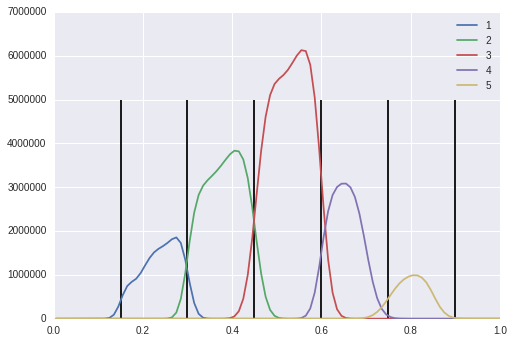

In [113]:
for zbin in xrange(1,6):
    plt.plot(nz_table.data['Z_MID'], nz_table.data['BIN%d'%zbin], label = str(zbin))
    
plt.vlines(z_bins, 0, 5e6)
plt.legend(loc='best')
#plt.xscale('log')
plt.xlim([0, 1.0])
plt.show()

In [99]:
nz_table.data['BIN1']

array([  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   1.40000000e+01,
         1.62000000e+02,   1.29000000e+03,   4.40600000e+03,
         5.30100000e+03,   5.65200000e+03,   7.78500000e+03,
         9.50500000e+03,   1.13660000e+04,   1.17040000e+04,
         1.15580000e+04,   1.24900000e+04,   1.31730000e+04,
         1.33370000e+04,   1.42350000e+04,   1.55660000e+04,
         1.50650000e+04,   1.47420000e+04,   1.38700000e+04,
         1.20280000e+04,   6.91000000e+03,   4.36700000e+03,
         3.21200000e+03,   2.32700000e+03,   1.64000000e+03,
         1.22400000e+03,   8.04000000e+02,   7.03000000e+02,
         4.61000000e+02,   2.80000000e+02,   2.14000000e+02,
         2.14000000e+02,   1.90000000e+02,   1.68000000e+02,
         1.34000000e+02,   1.14000000e+02,   7.10000000e+01,
         4.40000000e+01,

In [74]:
nd_mock.value/nd_cat

6.593912694871146

In [75]:
#compute the mean mass
mf = cat.calc_mf()
HOD = cat.calc_hod()
mass_bin_range = (9,16)
mass_bin_size = 0.01
mass_bins = np.logspace(mass_bin_range[0], mass_bin_range[1], int( (mass_bin_range[1]-mass_bin_range[0])/mass_bin_size )+1 )

mean_host_mass = np.sum([mass_bin_size*mf[i]*HOD[i]*(mass_bins[i]+mass_bins[i+1])/2 for i in xrange(len(mass_bins)-1)])/\
                    np.sum([mass_bin_size*mf[i]*HOD[i] for i in xrange(len(mass_bins)-1)])
print mean_host_mass

1.25501362409e+14


In [76]:
theta_bins = np.logspace(np.log10(2.5), np.log10(250), 21)/60 #binning used in buzzard mocks
tpoints = (theta_bins[1:]+theta_bins[:-1])/2

In [77]:
?? cat.calc_wt

In [78]:
r_bins = np.logspace(-0.5, 1.7, 16)
rpoints = (r_bins[1:]+r_bins[:-1])/2

In [79]:
r_bins

array([  0.31622777,   0.44326829,   0.62134575,   0.87096359,
         1.22086225,   1.7113283 ,   2.39883292,   3.36253386,
         4.71338954,   6.60693448,   9.26118728,  12.98175275,
        18.19700859,  25.50742784,  35.75471605,  50.11872336])

In [80]:
wt =  cat.calc_wt(theta_bins, r_bins, W)

InvalidCacheLogEntry: 
You tried to load a cached particle catalog with the following characteristics:

simname = ``chinchilla``
ptcl_version_name = ``halotools_v0p4``  (set by sim_defaults.default_version_name)
redshift = ``0.2327``

There is no matching catalog in cache within dz_tol = 0.01 of these inputs.

The following entries in the cache log most closely match your inputs:

('chinchilla', 'Lb400-2048', '0.0000', '/u/ki/swmclau2/des/halocats/ptcl_1.00.list.chinchilla_Lb400-2048.hdf5')

('chinchilla', 'Lb400-2048', '0.2000', '/u/ki/swmclau2/des/halocats/ptcl_0.83.list.chinchilla_Lb400-2048.hdf5')

('chinchilla', 'Lb400-2048', '0.2327', '/u/ki/swmclau2/des/halocats/ptcl_0.81.list.chinchilla_Lb400-2048.hdf5')

('chinchilla', 'Lb400-2048_particle_3.00', '0.0000', '/u/ki/swmclau2/des/halocats/ptcl_1.00.list.chinchilla_Lb400-2048.hdf5')

('chinchilla', 'Lb400-2048_particle_3.00', '0.2327', '/u/ki/swmclau2/des/halocats/ptcl_0.81.list.chinchilla_Lb400-2048.hdf5')



In [ ]:
wt

In [13]:
r_bins

NameError: name 'r_bins' is not defined

Use my code's wrapper for halotools' xi calculator. Full source code can be found [here](https://github.com/mclaughlin6464/pearce/blob/31e2f6a3598217dcf1be3d2606b69c4e529fc791/pearce/mocks/cat.py#L688).

In [22]:
xi = cat.calc_xi(r_bins, do_jackknife=False)

Interpolate with a Gaussian process. May want to do something else "at scale", but this is quick for now. 

In [23]:
import george
from george.kernels import ExpSquaredKernel
kernel = ExpSquaredKernel(0.05)
gp = george.GP(kernel)
gp.compute(np.log10(rpoints))

In [24]:
print xi

[  2.60657131e+03   1.23027666e+03   4.58736076e+02   1.49469349e+02
   4.17659588e+01   1.27924782e+01   6.01294431e+00   4.45841995e+00
   2.54847662e+00   1.36017653e+00   7.30093914e-01   3.86348464e-01
   1.74698080e-01   6.42636931e-02   2.12185559e-02]


In [25]:
xi[xi<=0] = 1e-2 #ack

In [26]:
from scipy.stats import linregress
m,b,_,_,_ = linregress(np.log10(rpoints), np.log10(xi))

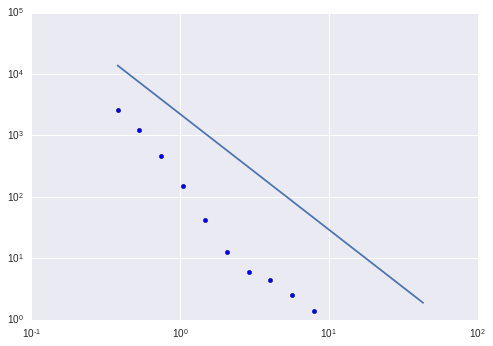

In [27]:
plt.plot(rpoints, (2.22353827e+03)*(rpoints**(-1.88359)))
#plt.plot(rpoints, b2*(rpoints**m2))

plt.scatter(rpoints, xi)
plt.loglog();

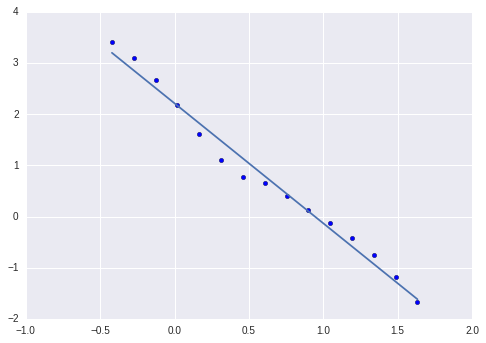

In [28]:
plt.plot(np.log10(rpoints), b+(np.log10(rpoints)*m))
#plt.plot(np.log10(rpoints), b2+(np.log10(rpoints)*m2))
#plt.plot(np.log10(rpoints), 90+(np.log10(rpoints)*(-2)))

plt.scatter(np.log10(rpoints), np.log10(xi) )
#plt.loglog();

In [29]:
print m,b

-2.34633655775 2.2132896


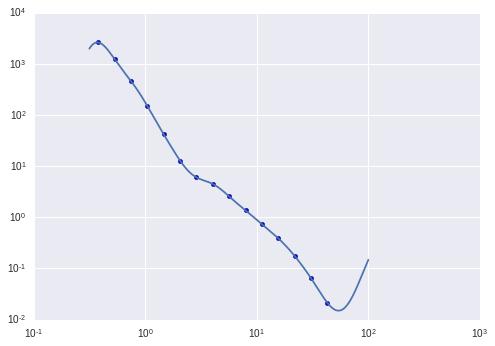

In [30]:
rpoints_dense = np.logspace(-0.5, 2, 500)

plt.scatter(rpoints, xi)
plt.plot(rpoints_dense, np.power(10, gp.predict(np.log10(xi), np.log10(rpoints_dense))[0]))
plt.loglog();

This plot looks bad on large scales. I will need to implement a linear bias model for larger scales; however I believe this is not the cause of this issue. The overly large correlation function at large scales if anything should increase w(theta). 

This plot shows the regimes of concern. The black lines show the value of r for u=0 in the below integral for each theta bin. The red lines show the maximum value of r for the integral I'm performing.

Perform the below integral in each theta bin:

$$ w(\theta) = W \int_0^\infty du \xi \left(r = \sqrt{u^2 + \bar{x}^2(z)\theta^2} \right) $$

Where $\bar{x}$ is the median comoving distance to z. 

In [36]:
#a subset of the data from above. I've verified it's correct, but we can look again. 
wt_redmagic = np.loadtxt('/u/ki/swmclau2/Git/pearce/bin/mcmc/buzzard2_wt_%d%d.npy'%(zbin,zbin))

The below plot shows the problem. There appears to be a constant multiplicative offset between the redmagic calculation and the one we just performed. The plot below it shows their ratio. It is near-constant, but there is some small radial trend. Whether or not it is significant is tough to say. 

In [37]:
from scipy.special import gamma
def wt_analytic(m,b,t,x):
    return W*b*np.sqrt(np.pi)*(t*x)**(1 + m)*(gamma(-(1./2) - m/2.)/(2*gamma(-(m/2.))) )

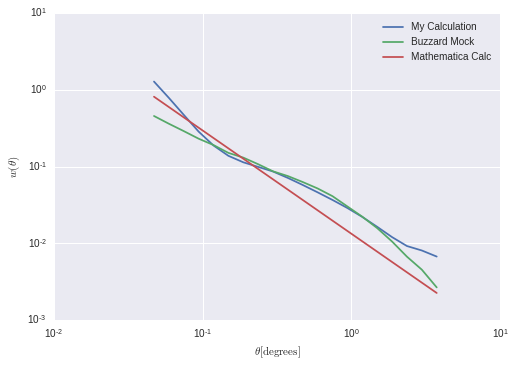

In [38]:
plt.plot(tpoints, wt, label = 'My Calculation')
plt.plot(tpoints_rm, wt_redmagic, label = 'Buzzard Mock')
#plt.plot(tpoints_rm, W.to("1/Mpc").value*mathematica_calc, label = 'Mathematica Calc')
plt.plot(tpoints, wt_analytic(m,10**b, np.radians(tpoints), x),label = 'Mathematica Calc' )

plt.ylabel(r'$w(\theta)$')
plt.xlabel(r'$\theta \mathrm{[degrees]}$')
plt.loglog();
plt.legend(loc='best')

In [ ]:
wt_redmagic/(W.to("1/Mpc").value*mathematica_calc)

In [ ]:
import cPickle as pickle
with open('/u/ki/jderose/ki23/bigbrother-addgals/bbout/buzzard-flock/buzzard-0/buzzard0_lb1050_xigg_ministry.pkl') as f:
    xi_rm = pickle.load(f)

In [ ]:
xi_rm.metrics[0].xi.shape

In [ ]:
xi_rm.metrics[0].mbins

In [ ]:
xi_rm.metrics[0].cbins

In [ ]:
#plt.plot(np.log10(rpoints), b2+(np.log10(rpoints)*m2))
#plt.plot(np.log10(rpoints), 90+(np.log10(rpoints)*(-2)))

plt.scatter(rpoints, xi)
for i in xrange(3):
    for j in xrange(3):
        plt.plot(xi_rm.metrics[0].rbins[:-1], xi_rm.metrics[0].xi[:,i,j,0])
plt.loglog();

In [ ]:
plt.subplot(211)
plt.plot(tpoints_rm, wt_redmagic/wt)
plt.xscale('log')
#plt.ylim([0,10])
plt.subplot(212)
plt.plot(tpoints_rm, wt_redmagic/wt)
plt.xscale('log')
plt.ylim([2.0,4])

In [ ]:
xi_rm.metrics[0].xi.shape

In [ ]:
xi_rm.metrics[0].rbins #Mpc/h

The below cell calculates the integrals jointly instead of separately. It doesn't change the results significantly, but is quite slow. I've disabled it for that reason. 

In [ ]:
x = cat.cosmology.comoving_distance(z)*a
#ubins = np.linspace(10**-6, 10**2.0, 1001)
ubins = np.logspace(-6, 2.0, 51)
ubc = (ubins[1:]+ubins[:-1])/2.0

#NLL
def liklihood(params, wt_redmagic,x, tpoints):
    #print _params
    #prior  = np.array([ PRIORS[pname][0] < v < PRIORS[pname][1] for v,pname in zip(_params, param_names)])
    #print param_names
    #print prior
    #if not np.all(prior):
    #    return 1e9
    #params = {p:v for p,v in zip(param_names, _params)}
    #cat.populate(params)
    #nd_cat =  cat.calc_analytic_nd(parmas)
    #wt = np.zeros_like(tpoints_rm[:-5])
    
    #xi = cat.calc_xi(r_bins, do_jackknife=False)
    #m,b,_,_,_ = linregress(np.log10(rpoints), np.log10(xi))
    
    #if np.any(xi < 0):
    #    return 1e9
    #kernel = ExpSquaredKernel(0.05)
    #gp = george.GP(kernel)
    #gp.compute(np.log10(rpoints))
    
    #for bin_no, t_med in enumerate(np.radians(tpoints_rm[:-5])):
    #    int_xi = 0
    #    for ubin_no, _u in enumerate(ubc):
    #        _du = ubins[ubin_no+1]-ubins[ubin_no]
    #        u = _u*unit.Mpc*a
    #        du = _du*unit.Mpc*a
            #print np.sqrt(u**2+(x*t_med)**2)
    #        r = np.sqrt((u**2+(x*t_med)**2))#*cat.h#not sure about the h
            #if r > unit.Mpc*10**1.7: #ignore large scales. In the full implementation this will be a transition to a bias model. 
            #    int_xi+=du*0
            #else:
                # the GP predicts in log, so i predict in log and re-exponate
            #    int_xi+=du*(np.power(10, \
            #            gp.predict(np.log10(xi), np.log10(r.value), mean_only=True)[0]))
    #        int_xi+=du*(10**b)*(r.to("Mpc").value**m)

        #print (((int_xi*W))/wt_redmagic[0]).to("m/m")
        #break
    #    wt[bin_no] = int_xi*W.to("1/Mpc")
        
    wt = wt_analytic(params[0],params[1], tpoints, x.to("Mpc").value)   
    chi2 = np.sum(((wt - wt_redmagic[:-5])**2)/(1e-3*wt_redmagic[:-5]) )
    
    #chi2=0
    #print nd_cat
    #print wt
    #chi2+= ((nd_cat-nd_mock.value)**2)/(1e-6)
    
    #mf = cat.calc_mf()
    #HOD = cat.calc_hod()
    #mass_bin_range = (9,16)
    #mass_bin_size = 0.01
    #mass_bins = np.logspace(mass_bin_range[0], mass_bin_range[1], int( (mass_bin_range[1]-mass_bin_range[0])/mass_bin_size )+1 )

    #mean_host_mass = np.sum([mass_bin_size*mf[i]*HOD[i]*(mass_bins[i]+mass_bins[i+1])/2 for i in xrange(len(mass_bins)-1)])/\
    #                    np.sum([mass_bin_size*mf[i]*HOD[i] for i in xrange(len(mass_bins)-1)])
        
    #chi2+=((13.35-np.log10(mean_host_mass))**2)/(0.2)
    print chi2
    return chi2 #nll

In [ ]:
print nd_mock
print wt_redmagic[:-5]

In [ ]:
import scipy.optimize as op

In [ ]:
results = op.minimize(liklihood, np.array([-2.2, 10**1.7]),(wt_redmagic,x, tpoints_rm[:-5]))

In [ ]:
results

In [ ]:
#plt.plot(tpoints_rm, wt, label = 'My Calculation')
plt.plot(tpoints_rm, wt_redmagic, label = 'Buzzard Mock')
plt.plot(tpoints_rm, wt_analytic(-1.88359, 2.22353827e+03,tpoints_rm, x.to("Mpc").value), label = 'Mathematica Calc')

plt.ylabel(r'$w(\theta)$')
plt.xlabel(r'$\theta \mathrm{[degrees]}$')
plt.loglog();
plt.legend(loc='best')

In [ ]:
plt.plot(np.log10(rpoints), np.log10(2.22353827e+03)+(np.log10(rpoints)*(-1.88)))
plt.scatter(np.log10(rpoints), np.log10(xi) )


In [ ]:
np.array([v for v in params.values()])